<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_formats = ["retina"]

#Week 8: Tracking donated organs
This week we'll use a reduced version of a fairly sensitive dataset to understand several decades of history in the flow of donated livers, kidneys, and pancreases.

We went through a [data request process](https://optn.transplant.hrsa.gov/data/view-data-reports/request-data/data-request-instructions/) with the Organ Procurement and Transplantation Network (OPTN) to get a robust dataset based on STAR (Standard Transplant Analysis and Research) files.  Because lots of personal information was added that's potentially identifying, we're being very careful with the files.  You can access the prepared data through Canvas for use with this notebook, and we'll ask that you deestroy it at the end of the semester.

In [ ]:
!pip install -q geopy seaborn statsmodels

In [ ]:
import sqlite3

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial

from geopy import distance
from shapely.geometry import Point

In [ ]:
# you will have to download the sqlite dataset from the secure location and point at the right path here

optn_df = pd.read_sql("SELECT * FROM optn", sqlite3.connect("/content/optn_reduced.sqlite3"))
optn_df["deceased_donor"] = optn_df["deceased_donor"].astype(bool)
optn_df["succeeded_1_year"] = optn_df["succeeded_1_year"].astype(bool)

In [ ]:
optn_df

,preservation_hours,recipient_age,donor_age,organ,deceased_donor,succeeded_1_year,donor_lat,donor_lon,transplant_lat,transplant_lon,transplant_year
0,6.1,30-59,60-99,liver,True,True,43.15,-75.18,42.27,-71.76,2017-2024
1,5.0,60-99,0-29,liver,True,True,41.25,-75.88,39.96,-75.20,2007-2016
2,5.7,30-59,30-59,liver,True,False,38.03,-84.51,35.13,-90.00,2017-2024
3,7.5,30-59,60-99,liver,True,True,37.66,-121.02,37.76,-122.46,2007-2016
4,5.3,30-59,0-29,liver,True,False,39.70,-104.84,40.66,-111.89,2017-2024
...,...,...,...,...,...,...,...,...,...,...,...
252054,9.4,30-59,30-59,pancreas,True,True,39.68,-105.16,32.24,-110.94,2017-2024
252055,0.2,30-59,0-29,pancreas,True,True,40.65,-73.93,40.79,-73.94,2017-2024
252056,15.5,30-59,30-59,pancreas,True,True,39.32,-81.51,40.00,-83.02,2007-2016
252057,10.5,30-59,0-29,pancreas,True,False,33.51,-86.80,38.92,-77.09,2017-2024


This block defines distance between the hospitals.  Since it's based on latitude and longitude, this is distance "as the crow flies."

In [ ]:
def transplant_distance_miles(row):
    return distance.distance(
        (row["donor_lat"], row["donor_lon"]),
        (row["transplant_lat"], row["transplant_lon"])
    ).miles

In [ ]:
optn_df["distance_miles"] = optn_df.apply(transplant_distance_miles, axis=1)

In [ ]:
optn_df

,preservation_hours,recipient_age,donor_age,organ,deceased_donor,succeeded_1_year,donor_lat,donor_lon,transplant_lat,transplant_lon,transplant_year,distance_miles
0,6.1,30-59,60-99,liver,True,True,43.15,-75.18,42.27,-71.76,2017-2024,184.370227
1,5.0,60-99,0-29,liver,True,True,41.25,-75.88,39.96,-75.20,2007-2016,95.925424
2,5.7,30-59,30-59,liver,True,False,38.03,-84.51,35.13,-90.00,2017-2024,364.858865
3,7.5,30-59,60-99,liver,True,True,37.66,-121.02,37.76,-122.46,2007-2016,79.198770
4,5.3,30-59,0-29,liver,True,False,39.70,-104.84,40.66,-111.89,2017-2024,378.821725
...,...,...,...,...,...,...,...,...,...,...,...,...
252054,9.4,30-59,30-59,pancreas,True,True,39.68,-105.16,32.24,-110.94,2017-2024,606.372260
252055,0.2,30-59,0-29,pancreas,True,True,40.65,-73.93,40.79,-73.94,2017-2024,9.674583
252056,15.5,30-59,30-59,pancreas,True,True,39.32,-81.51,40.00,-83.02,2007-2016,93.186212
252057,10.5,30-59,0-29,pancreas,True,False,33.51,-86.80,38.92,-77.09,2017-2024,657.765094


In [ ]:
organs = ["Liver", "Kidney"]

How many of each kind of organ do we have in the data?

In [ ]:
optn_df["organ"].value_counts()

,count
organ,
kidney,145246
liver,104246
pancreas,2567


For organs that were moved (distance>0), let's make a histogram to see the distribution of the **cold ischemic time** (time out of the body and on ice).  

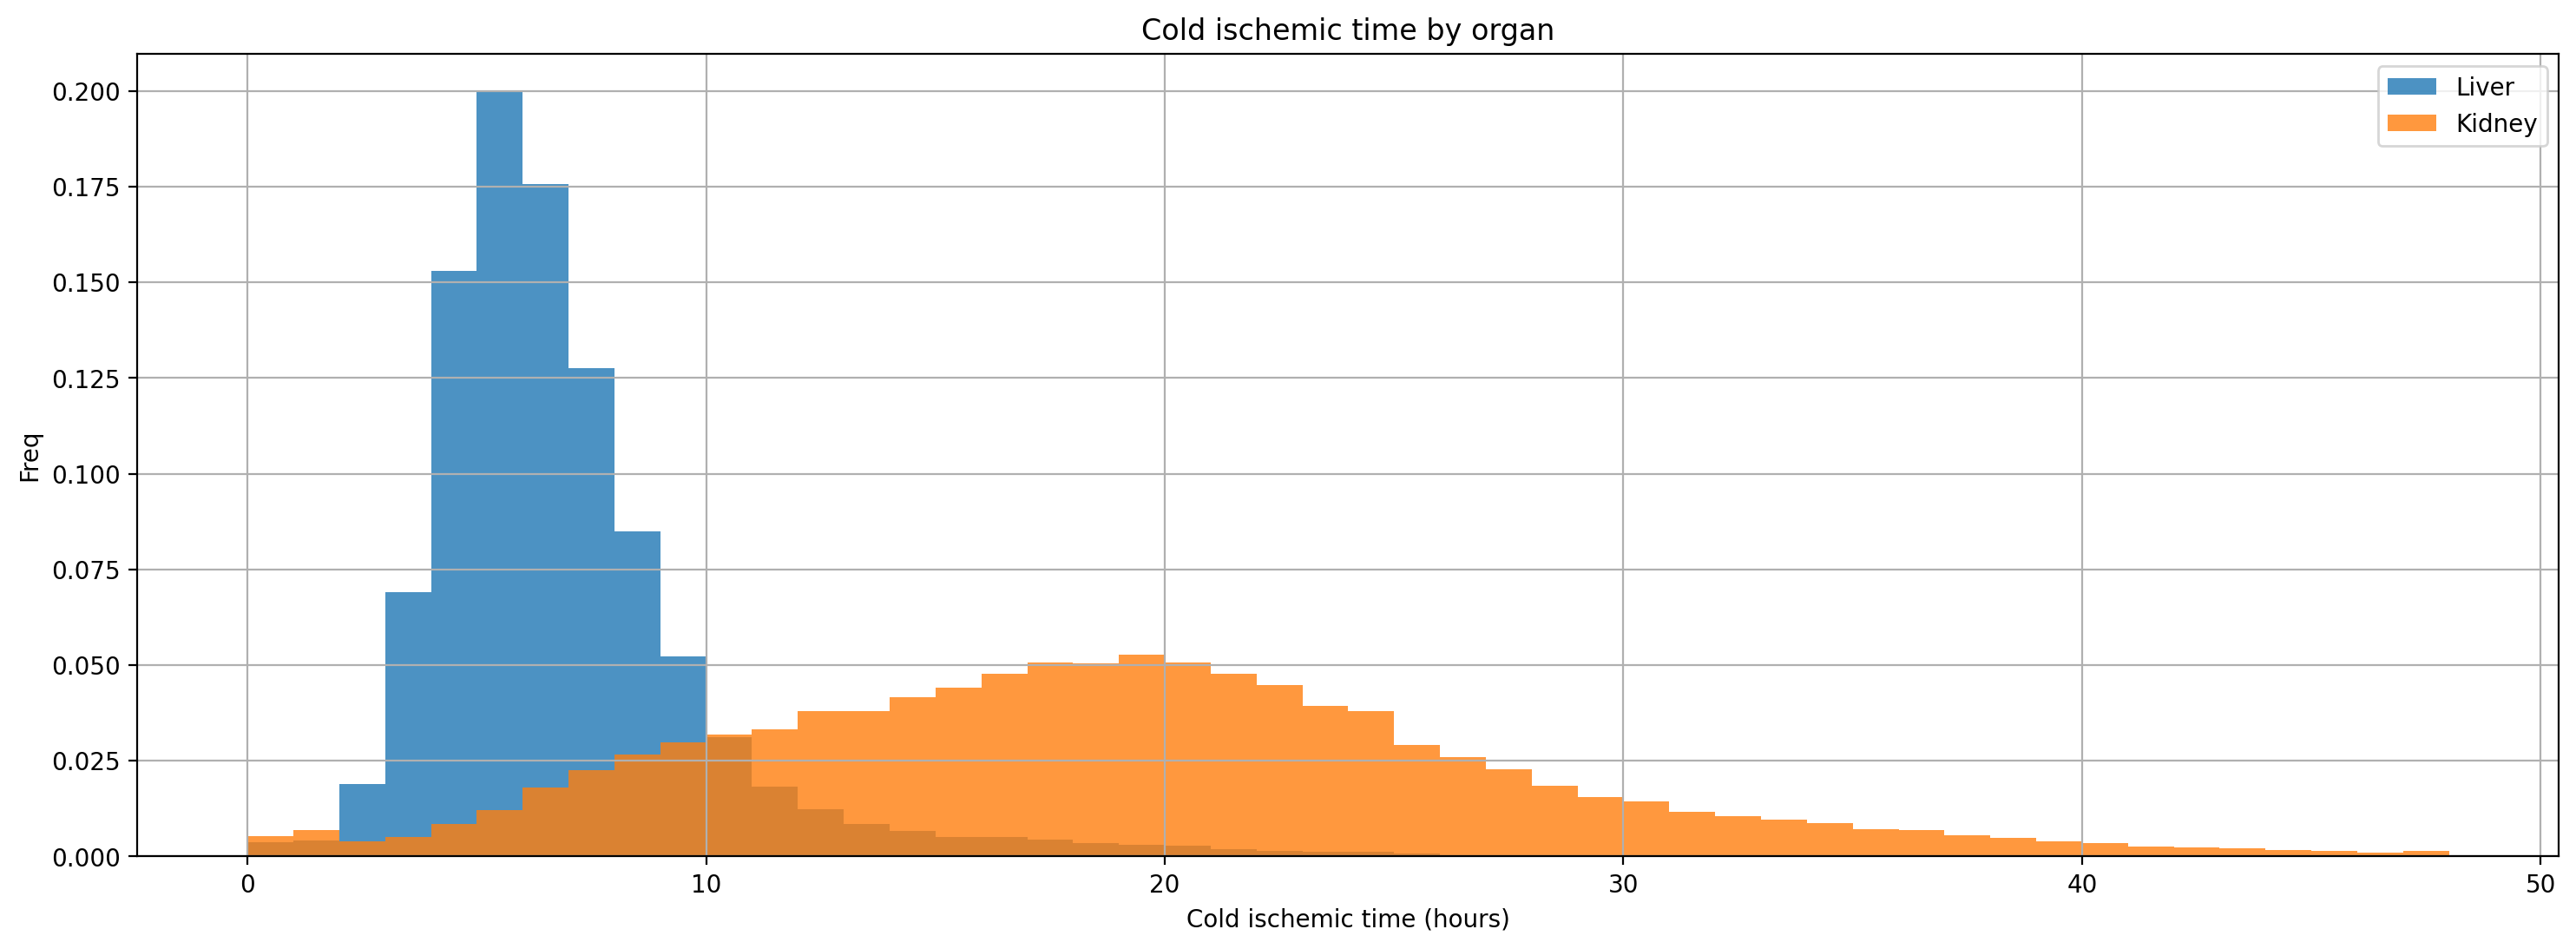

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
for organ in organs:
    optn_df[(optn_df["distance_miles"] > 0) & (optn_df["organ"] == organ.lower())].hist(
        "preservation_hours", ax=ax, alpha=0.8, bins=range(0, 49), density=True, label=organ,
    )

ax.set_title("Cold ischemic time by organ")
ax.set_xlabel("Cold ischemic time (hours)")
ax.set_ylabel("Freq")
plt.legend()
plt.show()

So it looks like kidneys are on ice longer.  Does that mean they travel farther?

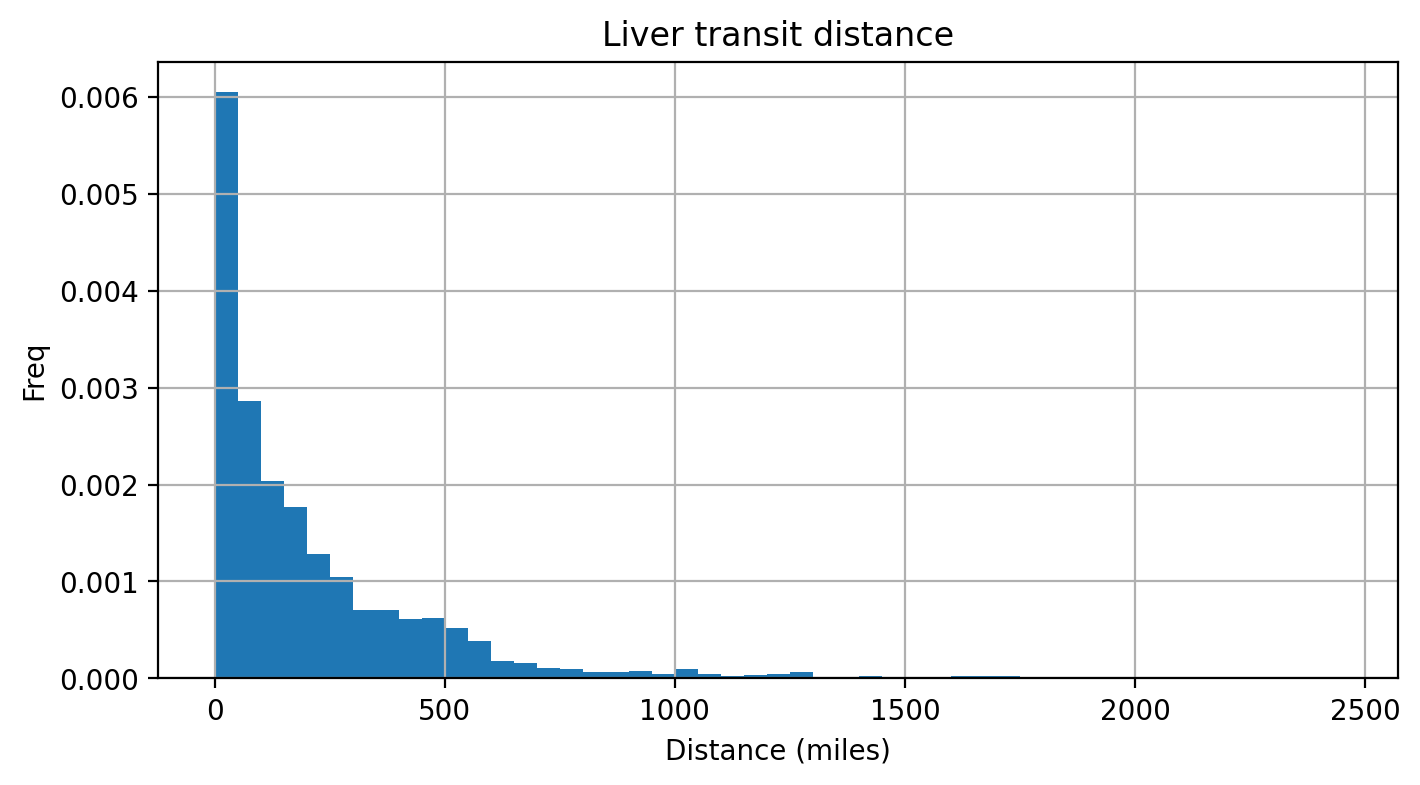

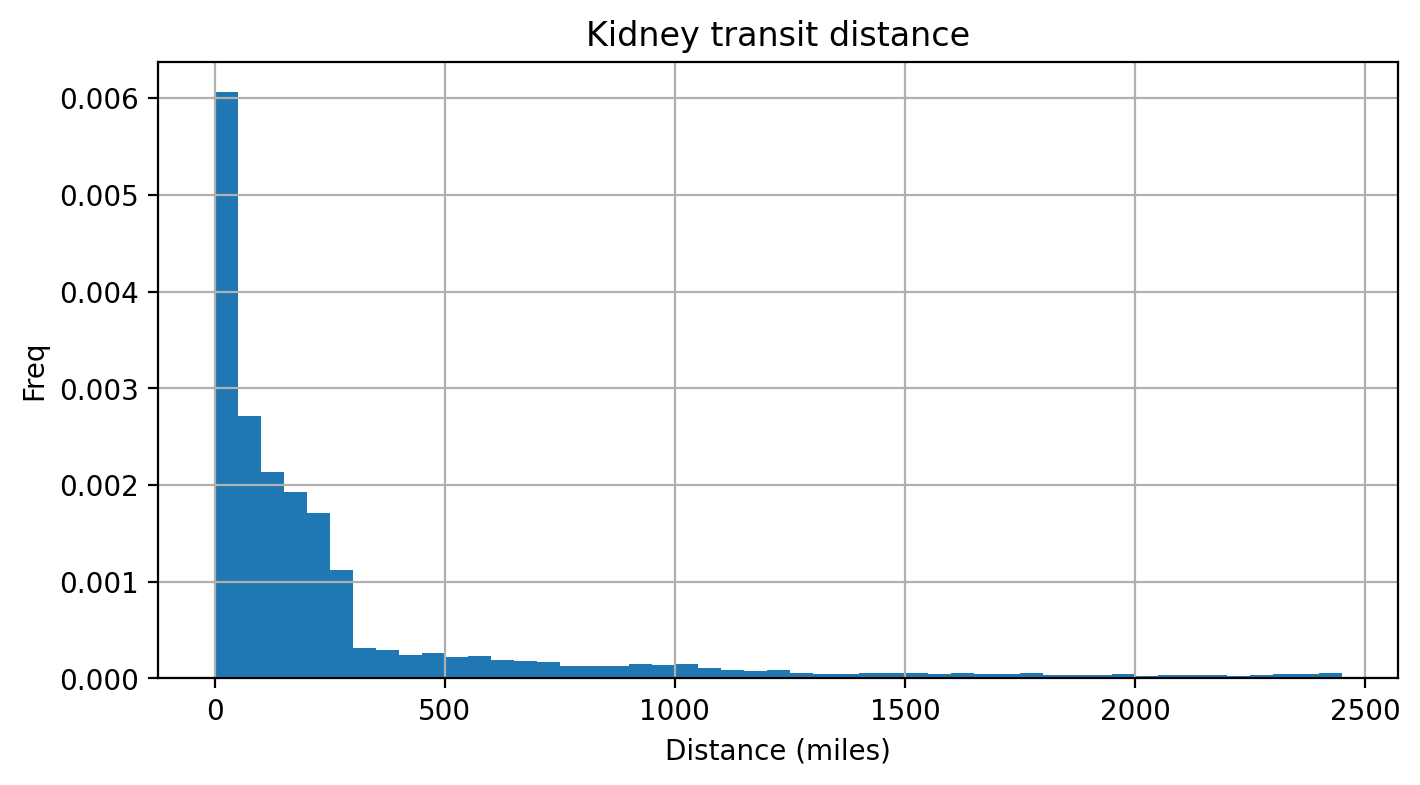

In [ ]:
for organ in organs:
    fig, ax = plt.subplots(figsize=(8, 4))
    optn_df[(optn_df["distance_miles"] > 0) & (optn_df["organ"] == organ.lower())].hist(
        "distance_miles", ax=ax, bins=range(0, 2500, 50),density=True, label=organ,
    )

    ax.set_title(f"{organ} transit distance")
    ax.set_xlabel("Distance (miles)")
    ax.set_ylabel("Freq")
    plt.show()

Maybe not.  OK so there must be a complicated relationship between cold time and transit distance.

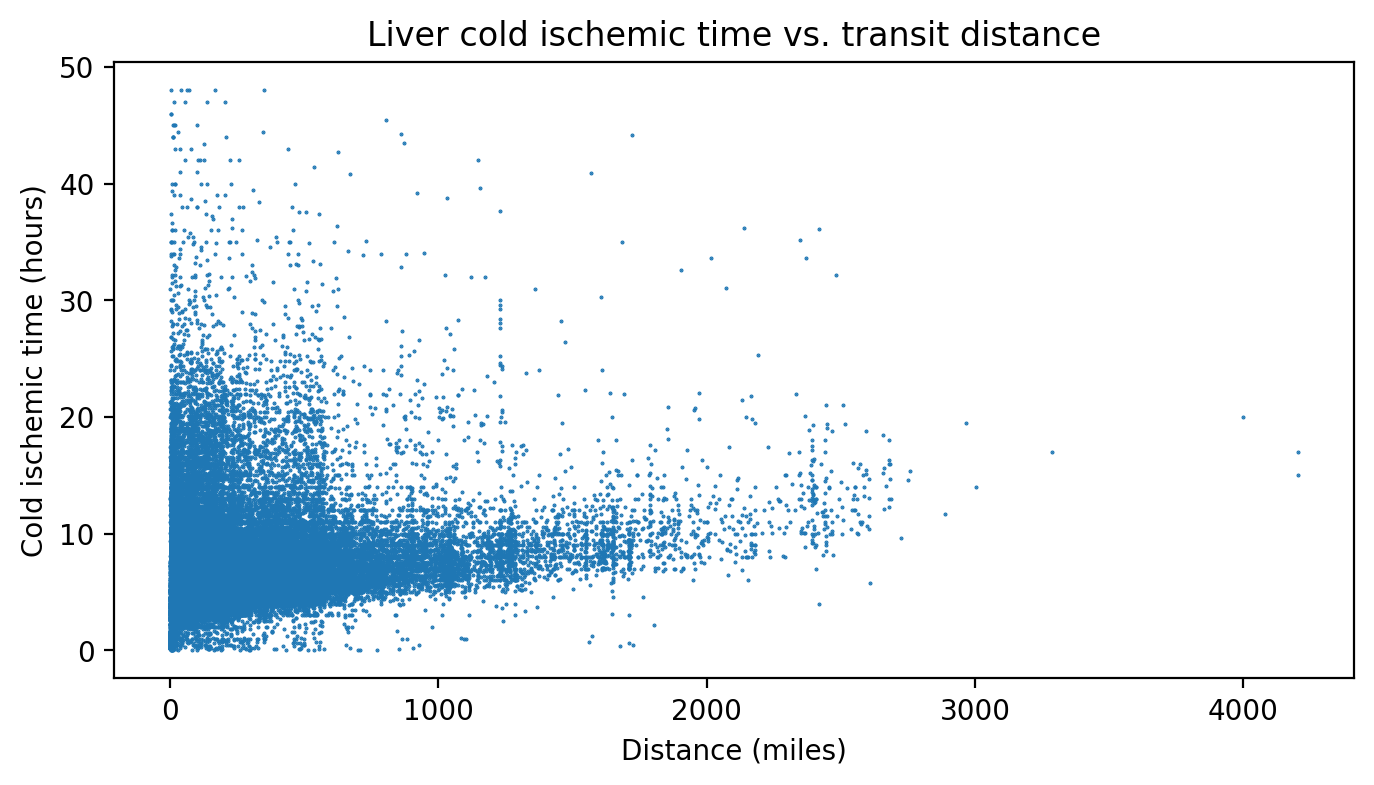

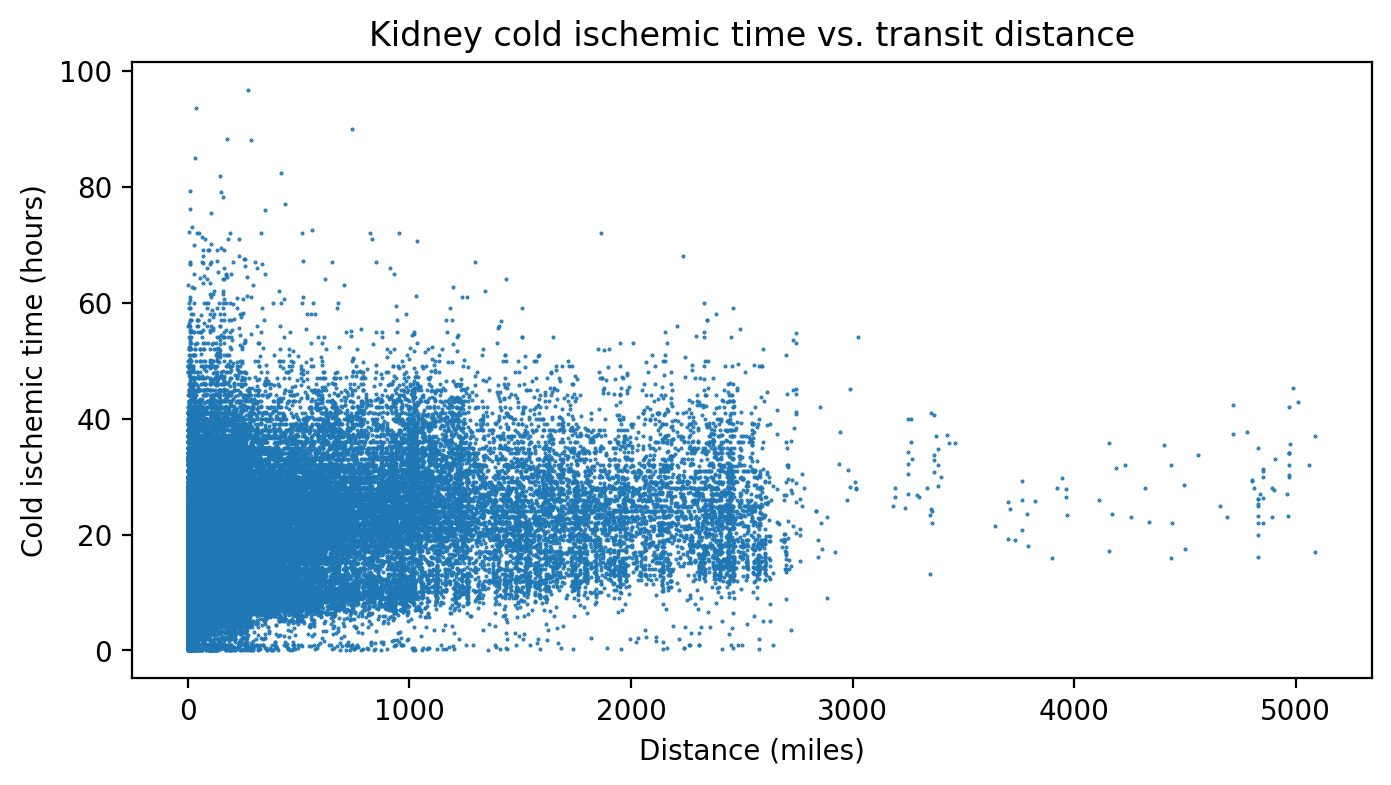

In [ ]:
for organ in organs:
    fig, ax = plt.subplots(figsize=(8, 4))
    optn_df[(optn_df["distance_miles"] > 0) & (optn_df["organ"] == organ.lower())].plot.scatter(
        y="preservation_hours", x="distance_miles", ax=ax, s=0.2,
    )
    ax.set_title(f"{organ} cold ischemic time vs. transit distance")
    ax.set_xlabel("Distance (miles)")
    ax.set_ylabel("Cold ischemic time (hours)")
    plt.show()

Those scatterplots have lots of interesting structure.  Now let's visualize the same data another way, using what's called a "KDE plot" (kernel density estimate).  This just takes the point data and smooths it out to see where the data is densest.

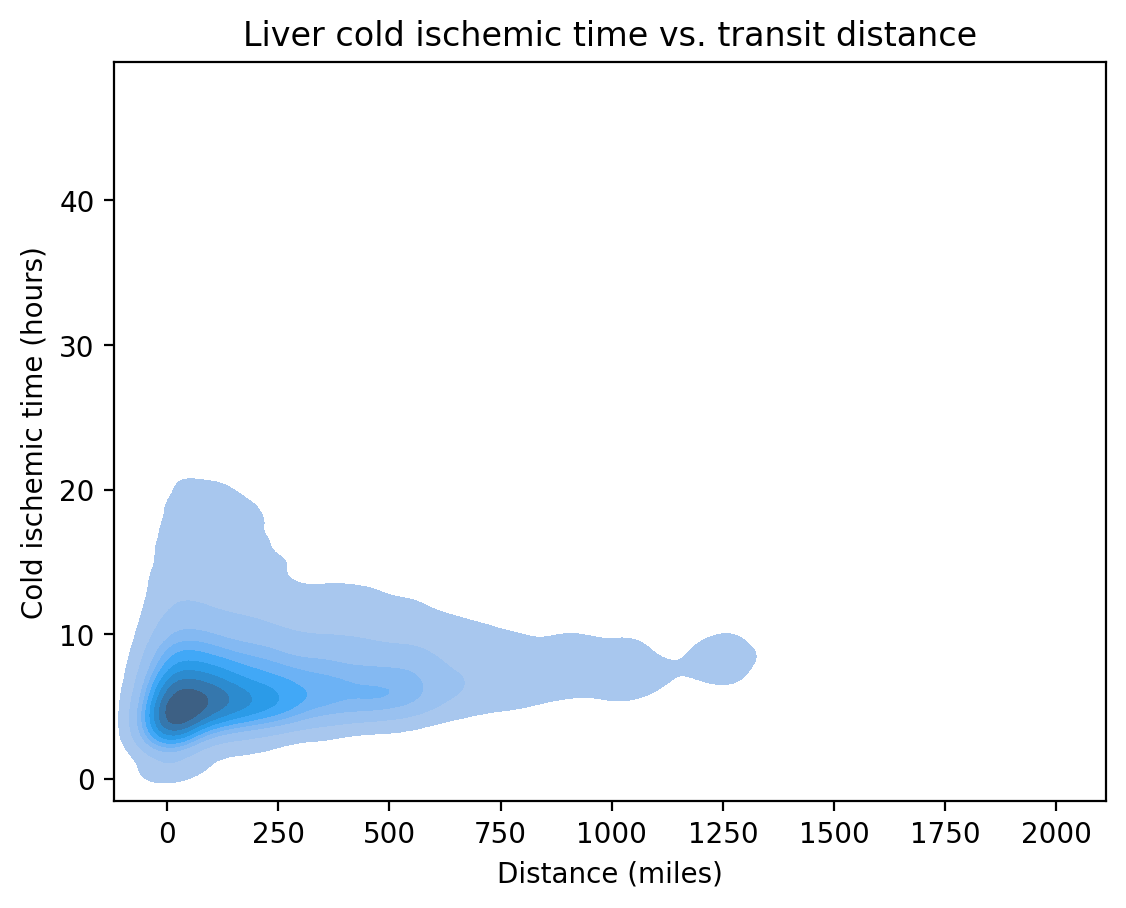

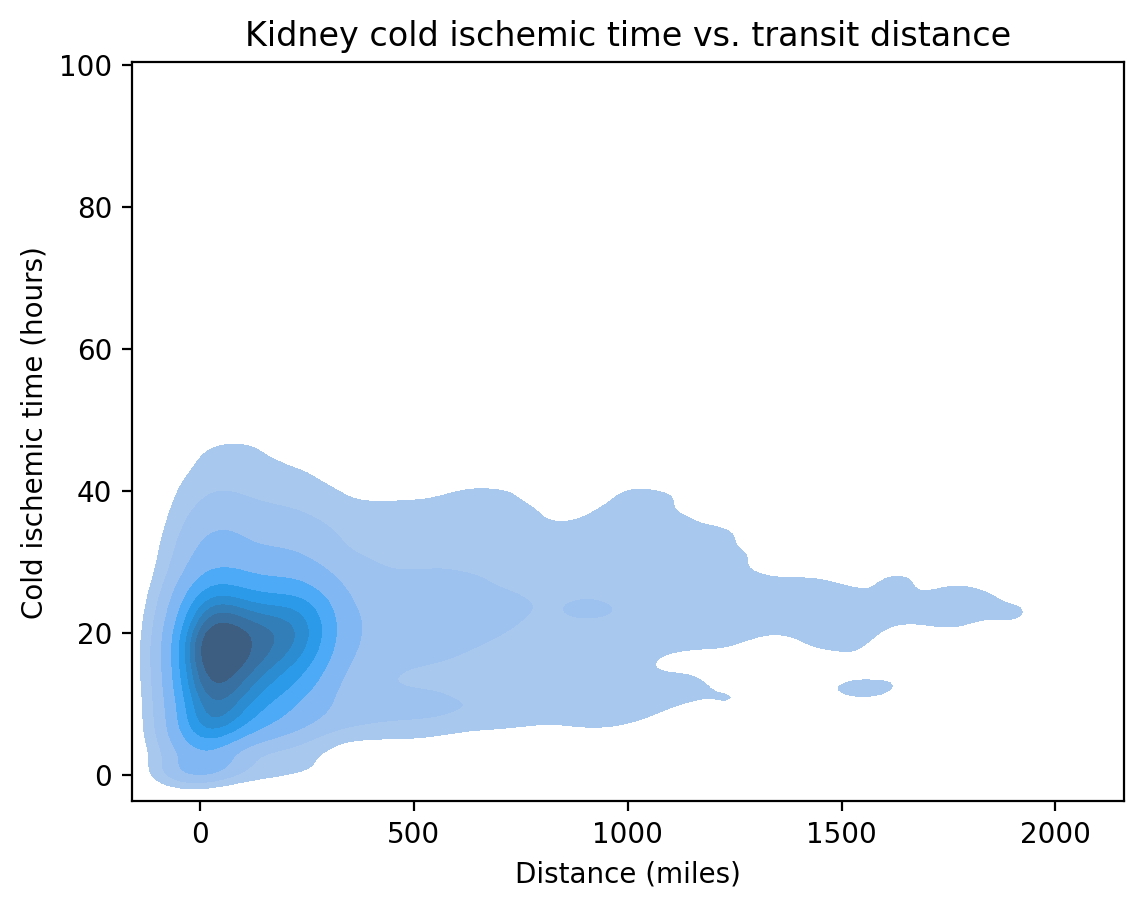

In [ ]:
for organ in organs:
    joint_df = optn_df[
        (optn_df["distance_miles"] > 0) &
        (optn_df["organ"] == organ.lower()) &
        (optn_df["distance_miles"] <= 2000)
    ]
    ax = sns.kdeplot(
        data=joint_df,
        x="distance_miles",
        y="preservation_hours",
        fill=True,
    )
    ax.set_title(f"{organ} cold ischemic time vs. transit distance")
    ax.set_xlabel("Distance (miles)")
    ax.set_ylabel("Cold ischemic time (hours)")
    plt.show()

Next, we'll use a technique called **logistic regression**.  This is a statistical technique for taking a bunch of data points of success and failure and fitting an S-shaped curve to the data.  The interpretation is that this is telling you an inferred PROBABILITY, learned from the data points.

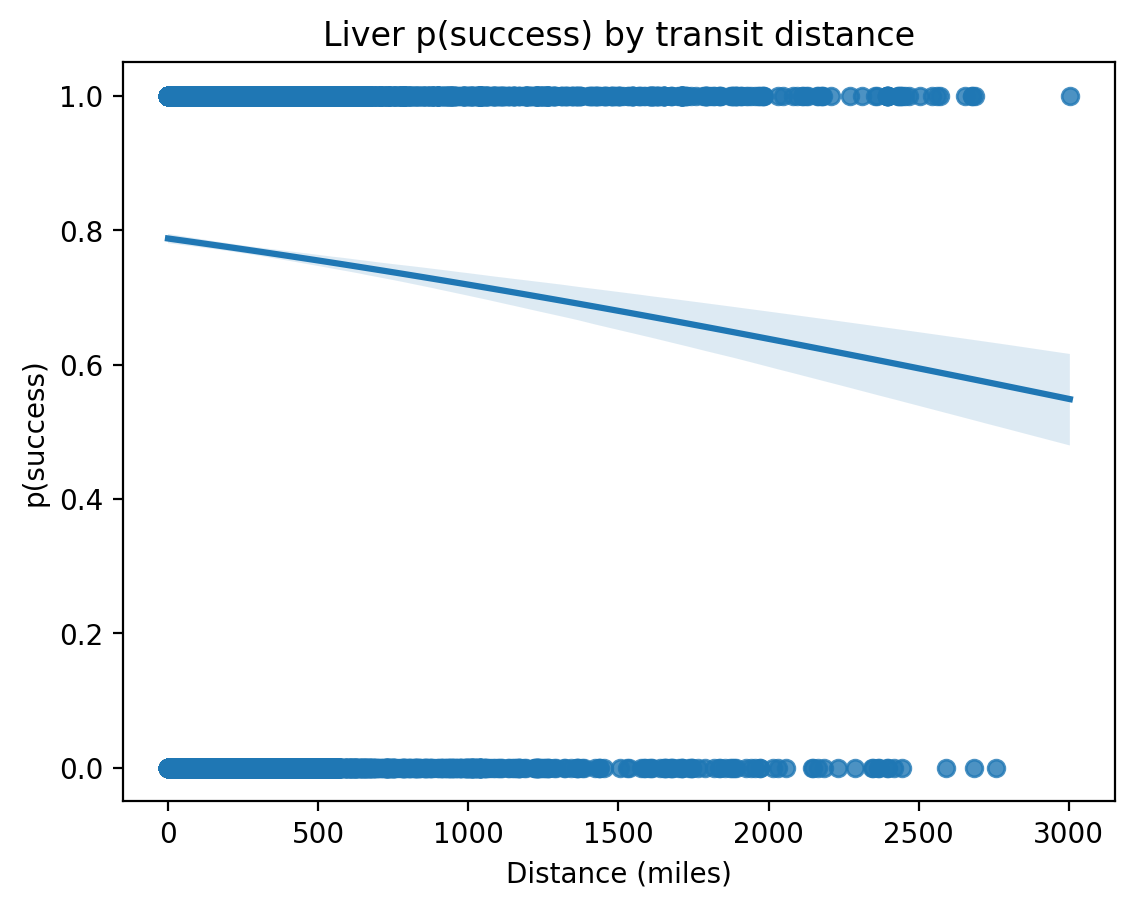

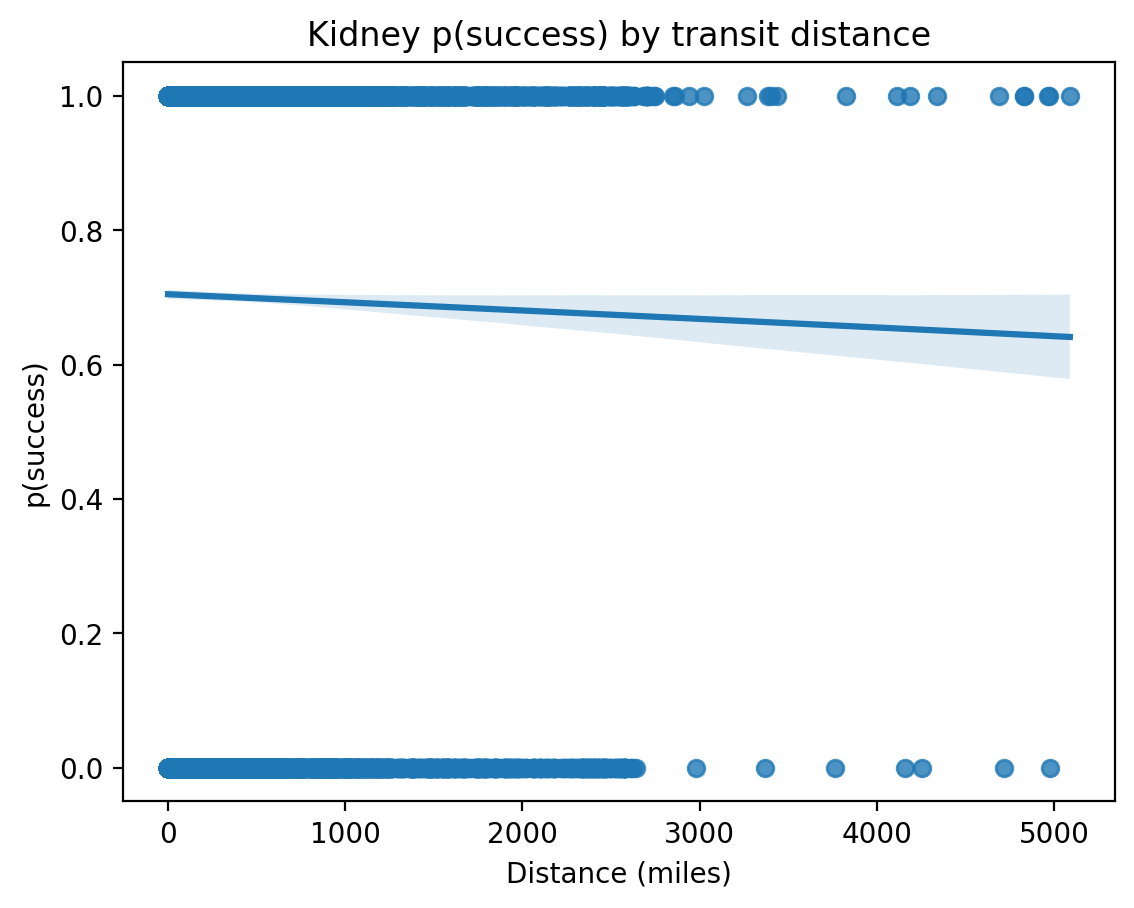

In [ ]:
for organ in organs:
    success_df = optn_df[
        (optn_df["distance_miles"] > 0) &
        (optn_df["organ"] == organ.lower())
    ].sample(frac=0.2)
    ax = sns.regplot(
        data=success_df,
        x=success_df["distance_miles"],
        y=success_df["succeeded_1_year"],
        logistic=True,
    )
    ax.set_title(f"{organ} p(success) by transit distance")
    ax.set_xlabel("Distance (miles)")
    ax.set_ylabel("p(success)")
    plt.show()

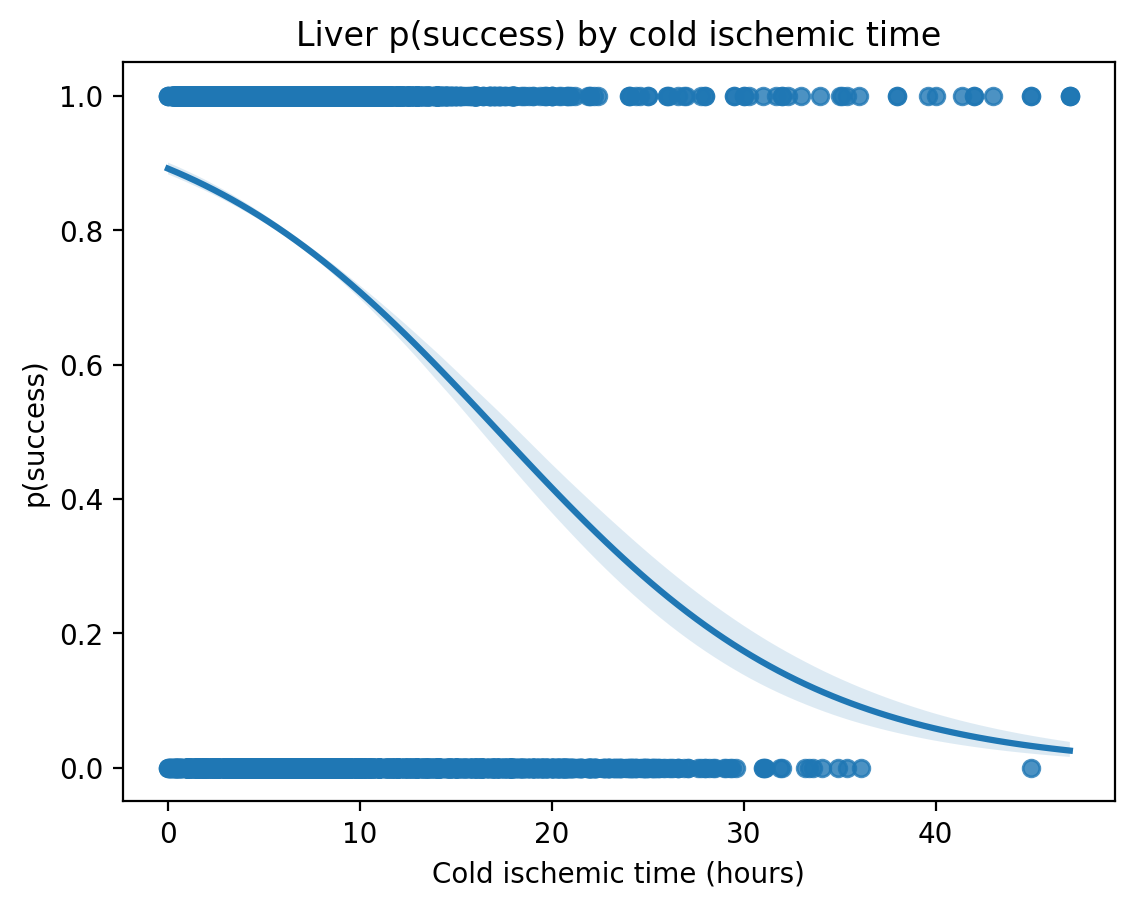

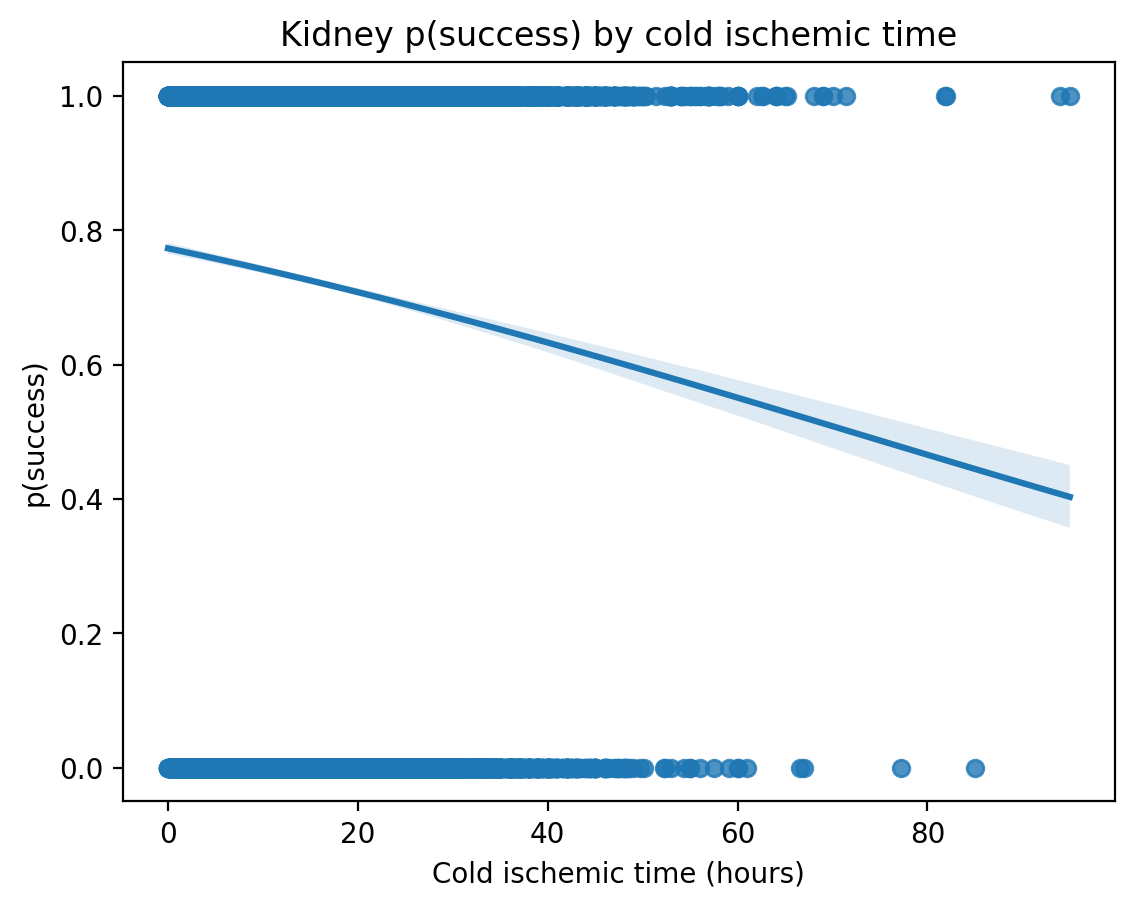

In [ ]:
for organ in organs:
    success_df = optn_df[(optn_df["organ"] == organ.lower())].sample(frac=0.2)
    ax = sns.regplot(
        data=success_df,
        x=success_df["preservation_hours"],
        y=success_df["succeeded_1_year"],
        logistic=True,
    )
    ax.set_title(f"{organ} p(success) by cold ischemic time")
    ax.set_xlabel("Cold ischemic time (hours)")
    ax.set_ylabel("p(success)")
    plt.show()

## Transplant volume by Census region/division

Everything we did above was using geospatial data basically just to see how far organs are shipped.  In this section we'll pay attention to where they are sent FROM and TO.

We'll use 4 census regions (Northeast, Midwest, South, and West) and we'll also subdivide those a little more finely into nine "[divisions](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)," to get a feel for how organs move around the country.

In [ ]:
region_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_region_500k.zip")

In [ ]:
division_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_division_500k.zip")

In [ ]:
def loc_to_label(row, label_gdf, prefix, cache=None):
    coords = (row[f"{prefix}_lon"], row[f"{prefix}_lat"])
    if cache and coords in cache:
        return cache[coords]

    p = Point(*coords)
    matches = label_gdf.iloc[label_gdf.sindex.query(p, predicate="intersects")]
    if not len(matches):
        return "N/A"

    assert len(matches) == 1
    cache[coords] = matches.iloc[0]["NAME"]
    return matches.iloc[0]["NAME"]

In [ ]:
region_cache = {}
optn_df["transplant_census_region"] = optn_df.apply(
    partial(loc_to_label, label_gdf=region_gdf, prefix="transplant", cache=region_cache),
    axis=1,
)
optn_df["donor_census_region"] = optn_df.apply(
    partial(loc_to_label, label_gdf=region_gdf, prefix="donor", cache=region_cache),
    axis=1,
)

In [ ]:
division_cache = {}
optn_df["transplant_census_division"] = optn_df.apply(
    partial(loc_to_label, label_gdf=division_gdf, prefix="transplant", cache=division_cache),
    axis=1,
)
optn_df["donor_census_division"] = optn_df.apply(
    partial(loc_to_label, label_gdf=division_gdf, prefix="donor", cache=division_cache),
    axis=1,
)

OK so all that info is packed into our dataframe.  We've got columns for how long the organ was preserved, for the donor and recipient age (chunked as 0-29, 30-59, or 60+ years old) and we'll show whether the graft was marked successful after one year.

(Later, if you play around with more of the data in the sqlite file, you'll see columns for success to 6 months, 2 years, etc.)

In [ ]:
optn_df

,preservation_hours,recipient_age,donor_age,organ,deceased_donor,succeeded_1_year,donor_lat,donor_lon,transplant_lat,transplant_lon,transplant_year,distance_miles,transplant_census_region,donor_census_region,transplant_census_division,donor_census_division
0,6.1,30-59,60-99,liver,True,True,43.15,-75.18,42.27,-71.76,2017-2024,184.370227,Northeast,Northeast,New England,Middle Atlantic
1,5.0,60-99,0-29,liver,True,True,41.25,-75.88,39.96,-75.20,2007-2016,95.925424,Northeast,Northeast,Middle Atlantic,Middle Atlantic
2,5.7,30-59,30-59,liver,True,False,38.03,-84.51,35.13,-90.00,2017-2024,364.858865,South,South,East South Central,East South Central
3,7.5,30-59,60-99,liver,True,True,37.66,-121.02,37.76,-122.46,2007-2016,79.198770,West,West,Pacific,Pacific
4,5.3,30-59,0-29,liver,True,False,39.70,-104.84,40.66,-111.89,2017-2024,378.821725,West,West,Mountain,Mountain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252054,9.4,30-59,30-59,pancreas,True,True,39.68,-105.16,32.24,-110.94,2017-2024,606.372260,West,West,Mountain,Mountain
252055,0.2,30-59,0-29,pancreas,True,True,40.65,-73.93,40.79,-73.94,2017-2024,9.674583,Northeast,Northeast,Middle Atlantic,Middle Atlantic
252056,15.5,30-59,30-59,pancreas,True,True,39.32,-81.51,40.00,-83.02,2007-2016,93.186212,Midwest,South,East North Central,South Atlantic
252057,10.5,30-59,0-29,pancreas,True,False,33.51,-86.80,38.92,-77.09,2017-2024,657.765094,South,South,South Atlantic,East South Central


In [ ]:
pd.crosstab(optn_df["transplant_census_region"], optn_df["donor_census_region"])

donor_census_region,Midwest,N/A,Northeast,South,West
transplant_census_region,,,,,
Midwest,54830,21,1355,5090,1642
Northeast,1987,115,33342,5545,835
South,4447,1060,4655,87426,1950
West,1651,9,588,1822,43689


In [ ]:
pd.crosstab(optn_df["transplant_census_division"], optn_df["donor_census_division"])

donor_census_division,East North Central,East South Central,Middle Atlantic,Mountain,N/A,New England,Pacific,South Atlantic,West North Central,West South Central
transplant_census_division,,,,,,,,,,
East North Central,34975,1667,884,325,19,157,405,1493,1815,502
East South Central,869,10659,113,102,101,33,118,2241,495,566
Middle Atlantic,1307,491,25135,319,100,1570,430,3984,484,495
Mountain,184,87,150,11454,3,49,1213,209,756,391
New England,132,98,1085,44,15,5552,42,390,64,87
Pacific,434,176,286,4690,6,103,26332,536,277,423
South Atlantic,1682,3715,3773,495,860,467,638,41920,564,1520
West North Central,2098,394,233,645,2,81,267,487,15942,547
West South Central,330,1015,214,311,99,55,286,1311,507,24479


# Homework 7 -- suggested due date Friday March 21 -- extended due date Tuesday March 25, 1:25pm

**Warmup question**: choose one census division from the table above, and choose one hospital in that division.  Figure out what city that hospital is in (reverse geocoding!).  You can do this by actually writing the lat, long coordinates in the Google Maps search bar, for example!  For that hospital, how many liver transplants did it receive in this whole dataset?  Explain how you figured it out.

**Data product**: as usual, use this notebook to get curious about some aspect of organ donation flows.  Formulate a question and make a data product that addresses it.  Briefly explain how you made it.

**Reading question**: This week's reading is by Kieran Healy on the sociology of organ donation.  He spends a good deal of space in the chapter discussing the ways that organ donation falls into a public policy gray area---is it best handled as a *gift* or by a *market*?  Pick out one quote from the chapter that relates to this tension between virtue and incentives.  (Cite the page your quote is on.)  Then give another example, not already covered in the chapter or the class discussion, of a policy question that falls in a gray area between gifts and markets.  Be creative!